# Reading bikes data

Raw bikes data is a collection of [request outputs](https://gbfs.citibikenyc.com/gbfs/en/station_status.json) in json, compressed with gzip.

Setup: Request outputs in `./data/bikes`

Example file: `1476890698_bikes.json.gz`

This notebook changes them into a dataframe csv `./data/bikes_{start}_{end}.csv`

Example contents:

In [36]:
import json
import gzip

def file_to_json(fname):
    with gzip.open(fname) as f:
        js = json.loads(f.read().decode('utf-8'))
        return js
        
# Return a subset of the data to understand
test_file = 'data/bikes/1476890698_bikes.json.gz'
test_json_full = file_to_json(test_file)
test_json = file_to_json(test_file)
test_json['data']['stations'] = test_json['data']['stations'][:10]

print(json.dumps(test_json, indent=2))

{
  "ttl": 10,
  "last_updated": 1476890698,
  "data": {
    "stations": [
      {
        "is_installed": 1,
        "station_id": "72",
        "num_bikes_disabled": 0,
        "num_bikes_available": 15,
        "is_renting": 1,
        "num_docks_disabled": 0,
        "is_returning": 1,
        "eightd_has_available_keys": false,
        "num_docks_available": 24,
        "last_reported": 1476890689
      },
      {
        "is_installed": 1,
        "station_id": "79",
        "num_bikes_disabled": 5,
        "num_bikes_available": 28,
        "is_renting": 1,
        "num_docks_disabled": 0,
        "is_returning": 1,
        "eightd_has_available_keys": false,
        "num_docks_available": 0,
        "last_reported": 1476888521
      },
      {
        "is_installed": 1,
        "station_id": "82",
        "num_bikes_disabled": 1,
        "num_bikes_available": 20,
        "is_renting": 1,
        "num_docks_disabled": 0,
        "is_returning": 1,
        "eightd_has_available_

Get the metadata about station IDs [here](https://gbfs.citibikenyc.com/gbfs/en/station_information.json).

## From JSON to DataFrame

It looks like all information is available from the `['data']['stations']` subobject. Each entry has a last update timestamp, docks disabled, bikes available, and so on. Let's turn all of this to a Data Frame.

In [37]:
import pandas as pd

def json_to_df(js):
    df = pd.DataFrame(js['data']['stations'])
    df['last_reported'] = pd.to_datetime(df['last_reported'], unit='s')
    df.sort_values(by=['last_reported', 'station_id'], inplace=True)
    return df

test_df = json_to_df(test_json)
test_df[:3]

,eightd_has_available_keys,is_installed,is_renting,is_returning,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,station_id
1,False,1,1,1,2016-10-19 14:48:41,28,5,0,0,79
5,False,1,1,1,2016-10-19 14:49:56,7,0,12,0,119
2,False,1,1,1,2016-10-19 14:56:58,20,1,6,0,82


In [38]:
test_df['last_reported']

1   2016-10-19 14:48:41
5   2016-10-19 14:49:56
2   2016-10-19 14:56:58
8   2016-10-19 15:20:23
6   2016-10-19 15:20:43
3   2016-10-19 15:21:40
4   2016-10-19 15:21:46
7   2016-10-19 15:24:19
0   2016-10-19 15:24:49
9   2016-10-19 15:24:56
Name: last_reported, dtype: datetime64[ns]

## Bulk Conversion

Okay, now that we can convert a single file to a data frame, let's convert the entire bikes subdirectory.

In [39]:
from os import listdir
from os.path import isfile, join

bikes_path = 'data/bikes'
bike_files = sorted([f for f in listdir(bikes_path) if isfile(join(bikes_path, f))])

bike_files[:10]

['1476711719_bikes.json.gz',
 '1476712198_bikes.json.gz',
 '1476712499_bikes.json.gz',
 '1476712801_bikes.json.gz',
 '1476713092_bikes.json.gz',
 '1476713394_bikes.json.gz',
 '1476713696_bikes.json.gz',
 '1476713997_bikes.json.gz',
 '1476714299_bikes.json.gz',
 '1476714601_bikes.json.gz']

In [40]:
# Drop all records that have update below this timestamp 
min_timestamp = 0

# Drop all records after this timestamp (exclusive).
max_timestamp = 10e15

# Read this many files
max_files = 100000

all_data = None
i = 0
for fname in bike_files[:max_files]:
    i += 1
    if i % 100 == 0:
        print(i, len(all_data))
        all_data = all_data.drop_duplicates(subset=['last_reported', 'station_id'])
    frame = json_to_df(file_to_json('data/bikes/' + fname))
    #frame = frame[frame['last_reported'] > min_timestamp]
    if len(frame) == 0:
        continue
    if all_data is None:
        all_data = frame
    else:
        all_data = pd.concat([all_data, frame])
    if i % 10 == 0:
        pre_len = len(all_data)

100 65736
200 93531
300 113273
400 131412
500 160341
600 176704
700 197740
800 230008
900 242467
1000 266059
1100 296659
1200 306538
1300 322003
1400 346880
1500 353709
1600 367783
1700 385920
1800 390793
1900 414119
2000 434620
2100 444080
2200 469874
2300 491727
2400 507901
2500 535385
2600 545235
2700 567398
2800 595356
2900 602003
3000 618878
3100 630133
3200 636249
3300 661025
3400 683135
3500 688075
3600 714401
3700 733003
3800 739837
3900 767748
4000 775858
4100 790103
4200 815977
4300 829541
4400 847733
4500 876226
4600 887249
4700 910240
4800 940898
4900 949409
5000 974786
5100 1003903
5200 1010947
5300 1038494
5400 1064735
5500 1070123
5600 1096068
5700 1117391
5800 1122329
5900 1147317
6000 1164374
6100 1173830
6200 1197232
6300 1217977
6400 1231473
6500 1258828
6600 1277853
6700 1293507
6800 1312900
6900 1324602
7000 1342039


In [41]:
len(all_data)

1337007

In [42]:
len(all_data.groupby(['last_reported', 'station_id']).agg('max'))

1311619

In [43]:
max(all_data['last_reported']) - min(all_data['last_reported'])

Timedelta('122 days 14:51:21')

In [44]:
max(all_data['last_reported'])

Timestamp('2016-11-11 05:04:57')

In [45]:
#Deduplicate data
dedup_data = all_data.drop_duplicates(subset=['last_reported', 'station_id'])

In [46]:
print(len(dedup_data))
dedup_data = dedup_data.sort_values(['last_reported', 'station_id'])
cut_data = dedup_data[100:]

1311667


In [47]:
print(len(cut_data))
start = min(cut_data['last_reported'])
end = max(cut_data['last_reported'])
start_ts = int(start.timestamp())
end_ts = int(end.timestamp())
print(start_ts, end_ts)
print(start)
print(end)

1311567
1476723624 1478858697
2016-10-17 13:00:24
2016-11-11 05:04:57


In [48]:
cut_data.to_csv('data/bikes_{}_{}.csv'.format(start_ts, end_ts), index=False)

In [49]:
updates_per_station = cut_data[['station_id', 'last_reported']].groupby(['station_id']).agg('count')
updates_per_station = updates_per_station.sort_values(by=['last_reported'], ascending=False)
updates_per_station[:10]

,last_reported
station_id,
320,5284
3263,5226
519,4789
285,4725
435,4621
477,4548
490,4513
507,4491
284,4460


1311519


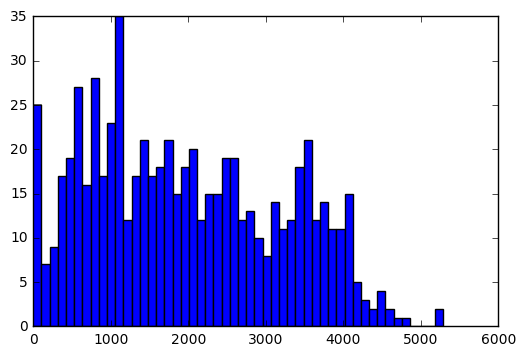

In [50]:
import matplotlib.pyplot as plt

print(sum(updates_per_station['last_reported']))
plt.figure()
plt.hist(updates_per_station['last_reported'], 50)
plt.show()